In [326]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

import discretize
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG import (
    maps,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
)
from SimPEG.electromagnetics import frequency_domain as fdem

## Setup

In [327]:
sigma_surface = 10e-3
sigma_middle = 20e-3
sigma_deep = 40e-3
sigma_air = 1e-8

In [335]:
z_interface_shallow_top = -500
z_interface_deep_top = -1000
x_dip_top = np.r_[5000, 9000]

z_interface_shallow_middle = -1000
z_interface_deep_middle = -2500
x_dip_middle = np.r_[2000, 7000]


def interface(x):
    # Top Interface
    interface_1 = np.zeros_like(x)
    interface_1[x < x_dip_top[0]] = z_interface_shallow_top
    dipping_unit = (x >= x_dip_top[0]) & (x <= x_dip_top[1])
    x_dipping = (-(z_interface_shallow_top - z_interface_deep_top) / x_dip_top[1]) * (
        x[dipping_unit]
    ) + z_interface_shallow_top
    interface_1[dipping_unit] = x_dipping
    interface_1[x > x_dip_top[1]] = z_interface_deep_top

    # Middle Interface
    interface_2 = np.zeros_like(x)
    dipping_unit = (x >= x_dip_middle[0]) & (x <= x_dip_middle[1])
    x_dipping = (-(z_interface_shallow_middle - z_interface_deep_middle) / x_dip_middle[1]) * (
        x[dipping_unit]
    ) + z_interface_shallow_middle
    interface_2[dipping_unit] = x_dipping
    interface_2[x > x_dip_middle[1]] = z_interface_deep_middle

    return interface_1, interface_2

## Forward Modelling Mesh

the mesh has 148500 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_20144\2922197969.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(core_domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_20144\2922197969.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(core_domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

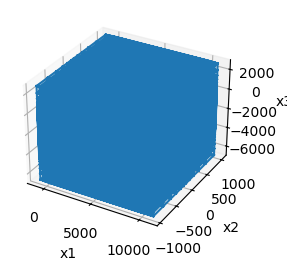

In [329]:
csx = 80  # cell size for the horizontal direction
csz = 50  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 5  # number of padding cells in the x-direction
npady = 5  # number of padding cells in the y-direction
npadz = 10  # number of padding cells in the z-direction

core_domain_x = np.r_[0.0, 10.0e3]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-4.0e3, 0.0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)

mesh.x0 = np.r_[
    -mesh.h[0][: npadx].sum(), -mesh.h[1][: npady].sum(), -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

## Inversion Mesh

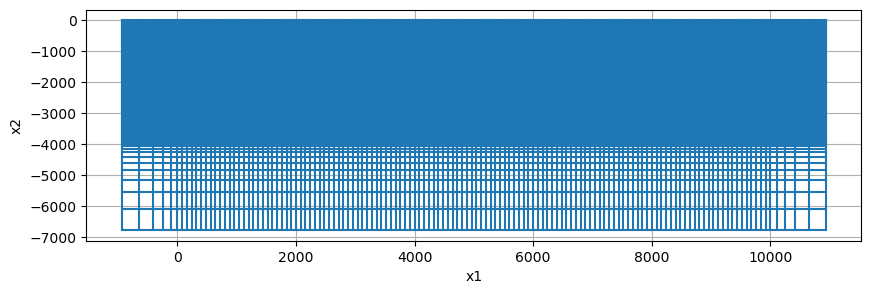

In [330]:
inversion_mesh = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh.x0 = [-inversion_mesh.h[0][mesh.cell_centers_x <= 0].sum(), -inversion_mesh.h[1].sum()]
ax = inversion_mesh.plot_grid()
plt.rcParams["figure.figsize"] = (10, 3)


## Survey

In [331]:
# Frequencies being predicted
frequencies = [100, 500, 2500]
# frequencies = np.logspace(-2, 8, 15)

# Defining transmitter locations
N = 9
xtx, ytx, ztx = np.meshgrid(np.linspace(-200, 200, N), np.linspace(-200, 200, N), [40])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(np.linspace(-200, 200, N), np.linspace(-200, 200, N), [20])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(len(frequencies)):
    for jj in range(ntx):
        # Define receivers of different type at each location
        bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "real"
        )
        bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "imag"
        )
        receivers_list = [bzr_receiver, bzi_receiver]

        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[ii],
                source_locations[jj],
                orientation="z",
                moment=100,
            )
        )

survey = fdem.Survey(source_list)

## Mapping

In [332]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, sigma_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh.nC
    )  # takes the exponential (log(sigma) --> sigma)
)

## True Model

(-4000.0, 0.0)

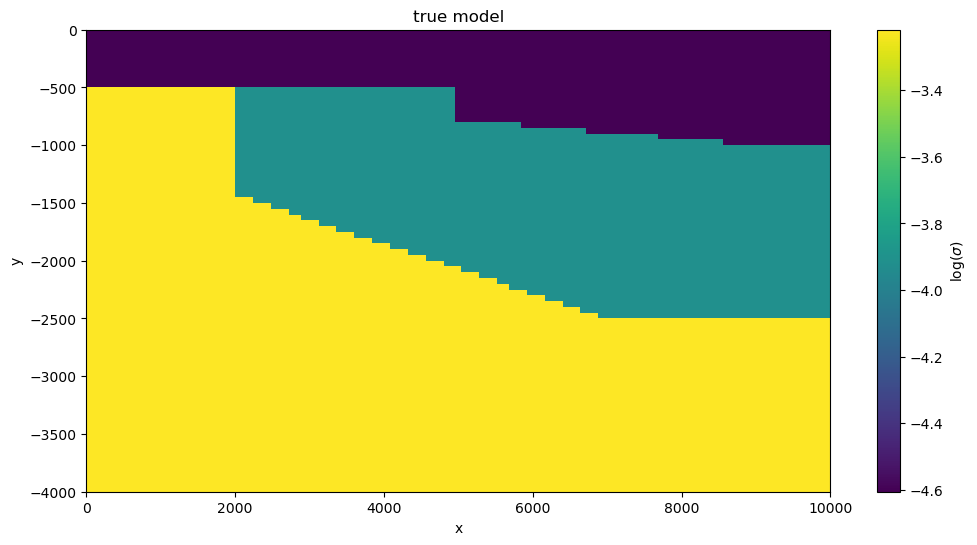

In [336]:
m_true = np.log(sigma_deep) * np.ones(inversion_mesh.nC)
interface_depth_1, interface_depth_2 = interface(inversion_mesh.gridCC[:, 0])
m_true[inversion_mesh.gridCC[:, 1] > interface_depth_2] = np.log(sigma_middle)
m_true[inversion_mesh.gridCC[:, 1] > interface_depth_1] = np.log(sigma_surface)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
cb = plt.colorbar(inversion_mesh.plot_image(m_true, ax=ax, grid=False)[0], ax=ax)
cb.set_label(r"$\log(\sigma)$")
ax.set_title("true model")
ax.set_xlim([0, 10e3])
ax.set_ylim([-4e3, 0])